# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    # yhnam
    return separable_conv2d_batchnorm(input_layer, filters, strides)

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    # Lesson 6-11
    concatenated = layers.concatenate([upsampled, large_ip_layer])
    # TODO Add some number of separable convolution layers
    # Lesson 6-9 
    preoutput_layer = separable_conv2d_batchnorm(concatenated, filters)
    output_layer = separable_conv2d_batchnorm(preoutput_layer, filters)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    filters = 32
    strides = 2
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    L1 = encoder_block(inputs, filters, strides)
    L2 = encoder_block(L1, filters*2, strides)
    L3 = encoder_block(L2, filters*4, strides)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    # Will be same size
    L2D = conv2d_batchnorm(L3, filters*4, kernel_size=1, strides=1) 
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_L1 = decoder_block(L2D, L2, filters*4)
    decoder_L2 = decoder_block(decoder_L1, L1, filters*2)
    decoder_L3 = decoder_block(decoder_L2, inputs, filters)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_L3)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.001
batch_size = 50
num_epochs = 100
steps_per_epoch = 70
validation_steps = 30
workers = 4

Epoch 1/100
69/70 [============================>.] - ETA: 0s - loss: 0.9121

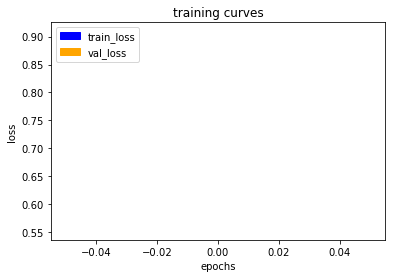

70/70 [==============================] - 70s - loss: 0.9076 - val_loss: 0.5545
Epoch 2/100
69/70 [============================>.] - ETA: 0s - loss: 0.3839

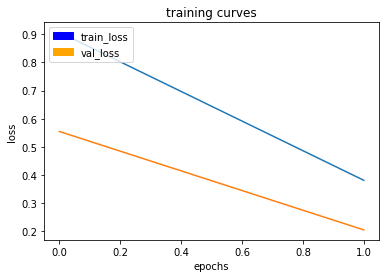

70/70 [==============================] - 65s - loss: 0.3816 - val_loss: 0.2044
Epoch 3/100
69/70 [============================>.] - ETA: 0s - loss: 0.1569

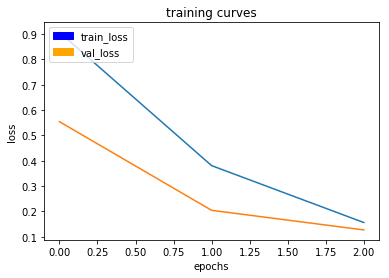

70/70 [==============================] - 66s - loss: 0.1562 - val_loss: 0.1270
Epoch 4/100
69/70 [============================>.] - ETA: 0s - loss: 0.0868

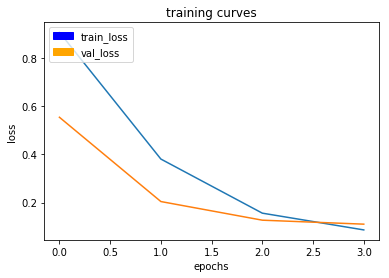

70/70 [==============================] - 66s - loss: 0.0865 - val_loss: 0.1105
Epoch 5/100
69/70 [============================>.] - ETA: 0s - loss: 0.0646

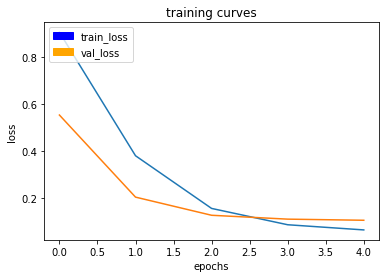

70/70 [==============================] - 66s - loss: 0.0644 - val_loss: 0.1057
Epoch 6/100
69/70 [============================>.] - ETA: 0s - loss: 0.0537

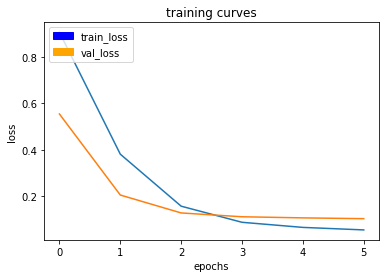

70/70 [==============================] - 66s - loss: 0.0536 - val_loss: 0.1022
Epoch 7/100
69/70 [============================>.] - ETA: 0s - loss: 0.0450

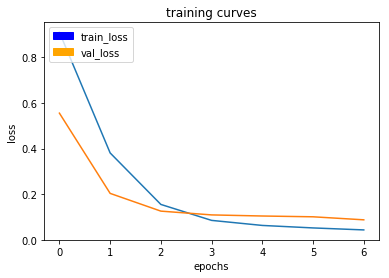

70/70 [==============================] - 67s - loss: 0.0450 - val_loss: 0.0890
Epoch 8/100
69/70 [============================>.] - ETA: 0s - loss: 0.0418

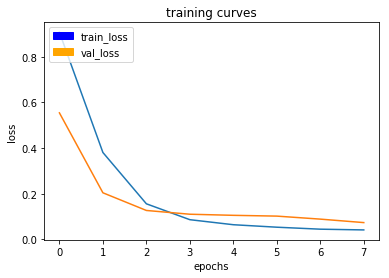

70/70 [==============================] - 66s - loss: 0.0417 - val_loss: 0.0738
Epoch 9/100
69/70 [============================>.] - ETA: 0s - loss: 0.0367

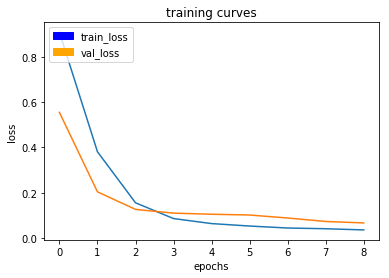

70/70 [==============================] - 66s - loss: 0.0366 - val_loss: 0.0673
Epoch 10/100
69/70 [============================>.] - ETA: 0s - loss: 0.0364

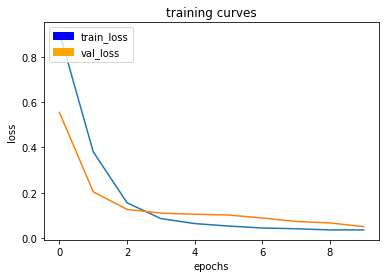

70/70 [==============================] - 66s - loss: 0.0365 - val_loss: 0.0510
Epoch 11/100
69/70 [============================>.] - ETA: 0s - loss: 0.0326

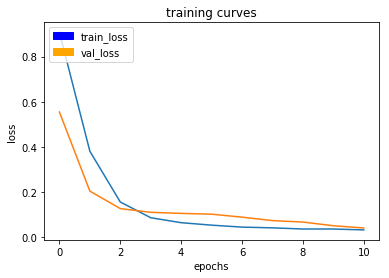

70/70 [==============================] - 66s - loss: 0.0325 - val_loss: 0.0412
Epoch 12/100
69/70 [============================>.] - ETA: 0s - loss: 0.0306

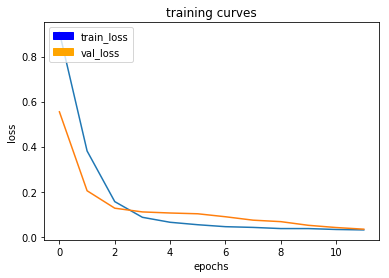

70/70 [==============================] - 66s - loss: 0.0306 - val_loss: 0.0339
Epoch 13/100
69/70 [============================>.] - ETA: 0s - loss: 0.0301

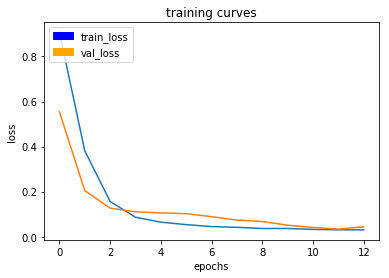

70/70 [==============================] - 66s - loss: 0.0302 - val_loss: 0.0440
Epoch 14/100
69/70 [============================>.] - ETA: 0s - loss: 0.0311

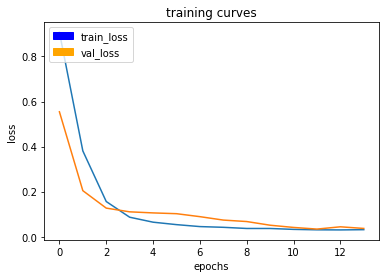

70/70 [==============================] - 66s - loss: 0.0312 - val_loss: 0.0367
Epoch 15/100
69/70 [============================>.] - ETA: 0s - loss: 0.0262

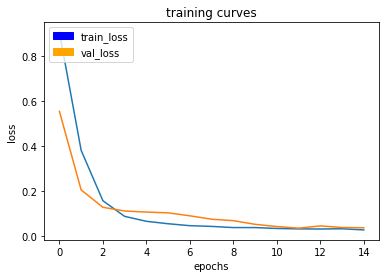

70/70 [==============================] - 66s - loss: 0.0261 - val_loss: 0.0356
Epoch 16/100
69/70 [============================>.] - ETA: 0s - loss: 0.0271

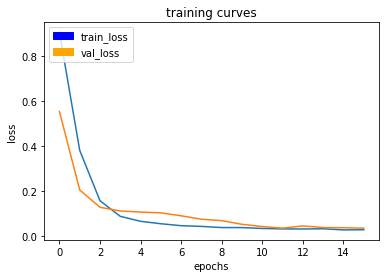

70/70 [==============================] - 66s - loss: 0.0270 - val_loss: 0.0338
Epoch 17/100
69/70 [============================>.] - ETA: 0s - loss: 0.0285

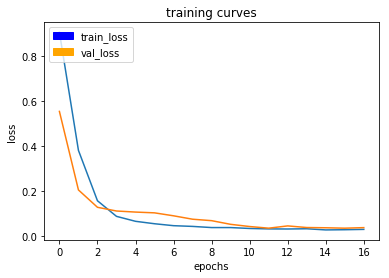

70/70 [==============================] - 66s - loss: 0.0285 - val_loss: 0.0363
Epoch 18/100
69/70 [============================>.] - ETA: 0s - loss: 0.0248

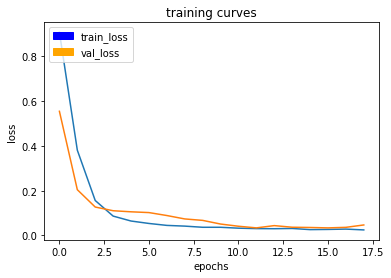

70/70 [==============================] - 66s - loss: 0.0247 - val_loss: 0.0469
Epoch 19/100
69/70 [============================>.] - ETA: 0s - loss: 0.0250

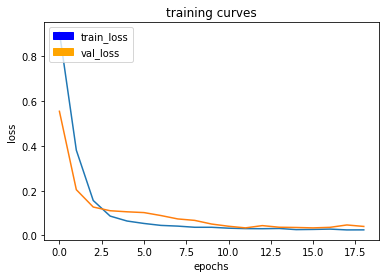

70/70 [==============================] - 66s - loss: 0.0250 - val_loss: 0.0403
Epoch 20/100
69/70 [============================>.] - ETA: 0s - loss: 0.0250

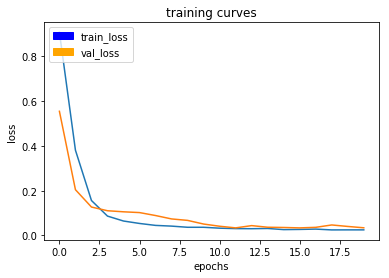

70/70 [==============================] - 66s - loss: 0.0250 - val_loss: 0.0342
Epoch 21/100
69/70 [============================>.] - ETA: 0s - loss: 0.0239

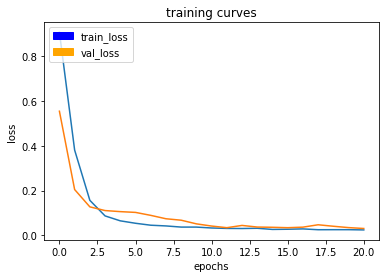

70/70 [==============================] - 66s - loss: 0.0239 - val_loss: 0.0303
Epoch 22/100
69/70 [============================>.] - ETA: 0s - loss: 0.0242

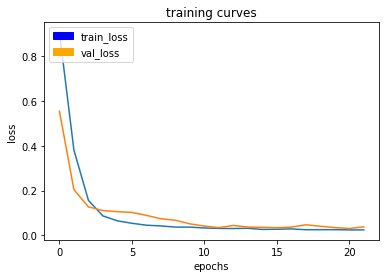

70/70 [==============================] - 66s - loss: 0.0241 - val_loss: 0.0377
Epoch 23/100
69/70 [============================>.] - ETA: 0s - loss: 0.0234

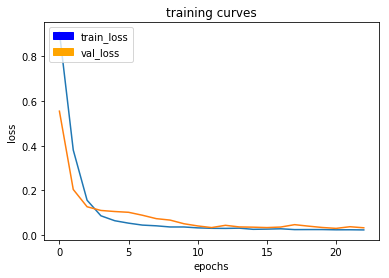

70/70 [==============================] - 66s - loss: 0.0234 - val_loss: 0.0329
Epoch 24/100
69/70 [============================>.] - ETA: 0s - loss: 0.0210

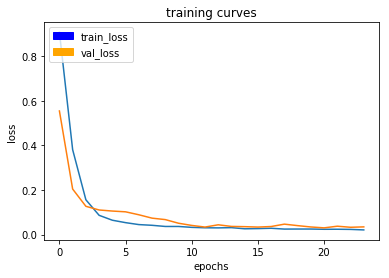

70/70 [==============================] - 66s - loss: 0.0210 - val_loss: 0.0347
Epoch 25/100
69/70 [============================>.] - ETA: 0s - loss: 0.0220

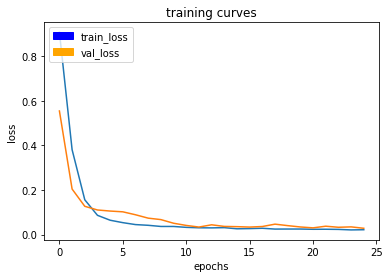

70/70 [==============================] - 66s - loss: 0.0219 - val_loss: 0.0284
Epoch 26/100
69/70 [============================>.] - ETA: 0s - loss: 0.0214

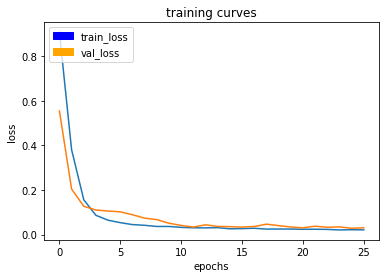

70/70 [==============================] - 66s - loss: 0.0213 - val_loss: 0.0307
Epoch 27/100
69/70 [============================>.] - ETA: 0s - loss: 0.0212

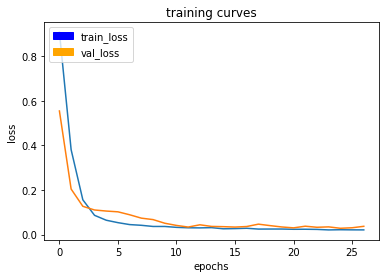

70/70 [==============================] - 66s - loss: 0.0212 - val_loss: 0.0372
Epoch 28/100
69/70 [============================>.] - ETA: 0s - loss: 0.0199

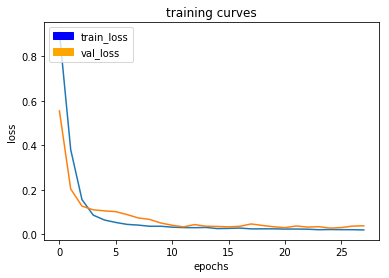

70/70 [==============================] - 66s - loss: 0.0202 - val_loss: 0.0388
Epoch 29/100
69/70 [============================>.] - ETA: 0s - loss: 0.0203

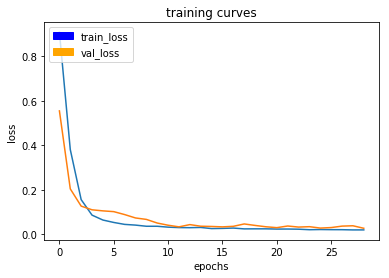

70/70 [==============================] - 66s - loss: 0.0202 - val_loss: 0.0275
Epoch 30/100
69/70 [============================>.] - ETA: 0s - loss: 0.0240

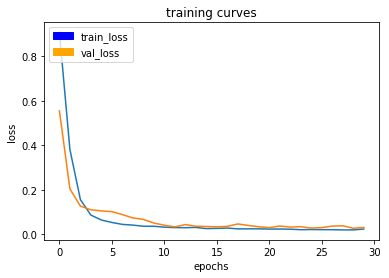

70/70 [==============================] - 66s - loss: 0.0240 - val_loss: 0.0313
Epoch 31/100
69/70 [============================>.] - ETA: 0s - loss: 0.0202

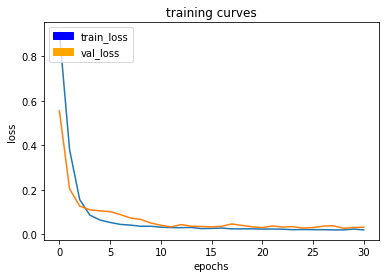

70/70 [==============================] - 66s - loss: 0.0202 - val_loss: 0.0320
Epoch 32/100
69/70 [============================>.] - ETA: 0s - loss: 0.0194

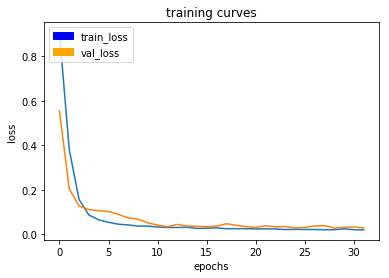

70/70 [==============================] - 66s - loss: 0.0193 - val_loss: 0.0286
Epoch 33/100
69/70 [============================>.] - ETA: 0s - loss: 0.0198

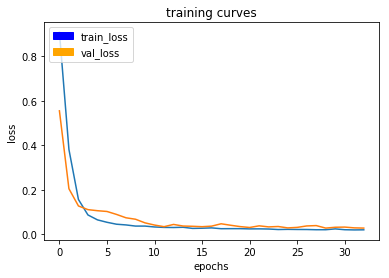

70/70 [==============================] - 66s - loss: 0.0198 - val_loss: 0.0275
Epoch 34/100
69/70 [============================>.] - ETA: 0s - loss: 0.0177

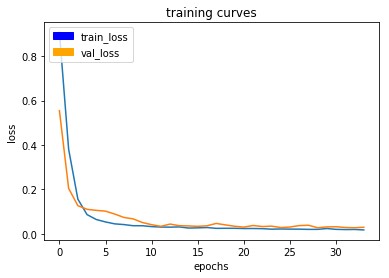

70/70 [==============================] - 66s - loss: 0.0177 - val_loss: 0.0297
Epoch 35/100
69/70 [============================>.] - ETA: 0s - loss: 0.0198

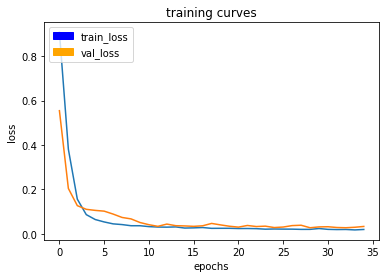

70/70 [==============================] - 66s - loss: 0.0198 - val_loss: 0.0333
Epoch 36/100
69/70 [============================>.] - ETA: 0s - loss: 0.0181

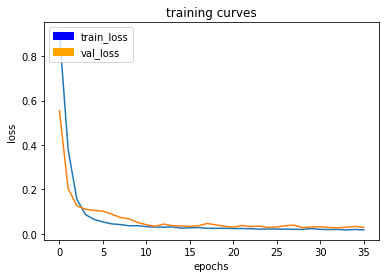

70/70 [==============================] - 66s - loss: 0.0181 - val_loss: 0.0289
Epoch 37/100
69/70 [============================>.] - ETA: 0s - loss: 0.0191

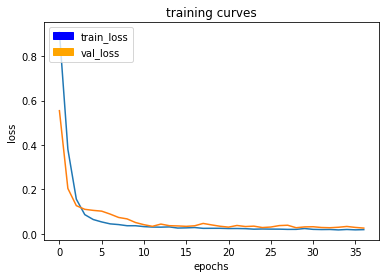

70/70 [==============================] - 66s - loss: 0.0190 - val_loss: 0.0260
Epoch 38/100
69/70 [============================>.] - ETA: 0s - loss: 0.0185

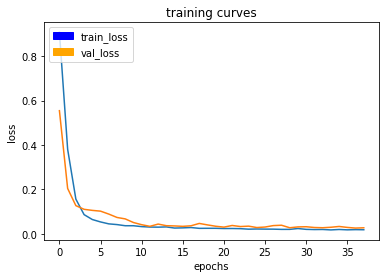

70/70 [==============================] - 66s - loss: 0.0185 - val_loss: 0.0273
Epoch 39/100
69/70 [============================>.] - ETA: 0s - loss: 0.0180

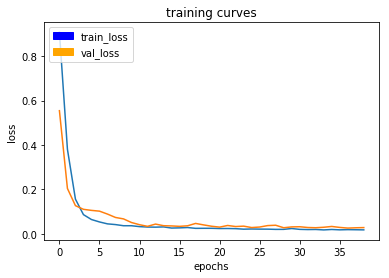

70/70 [==============================] - 66s - loss: 0.0179 - val_loss: 0.0282
Epoch 40/100
69/70 [============================>.] - ETA: 0s - loss: 0.0184

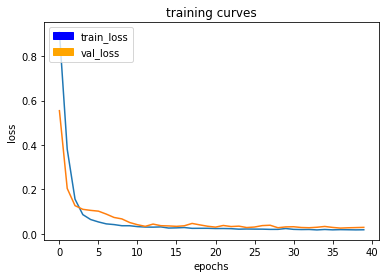

70/70 [==============================] - 65s - loss: 0.0184 - val_loss: 0.0292
Epoch 41/100
69/70 [============================>.] - ETA: 0s - loss: 0.0186

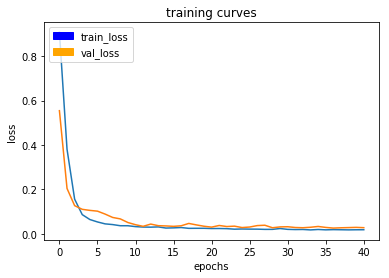

70/70 [==============================] - 66s - loss: 0.0186 - val_loss: 0.0278
Epoch 42/100
69/70 [============================>.] - ETA: 0s - loss: 0.0158

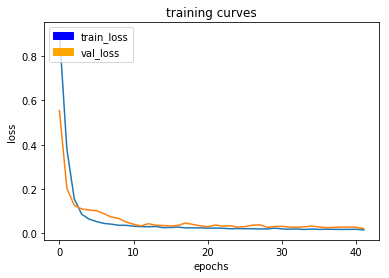

70/70 [==============================] - 66s - loss: 0.0158 - val_loss: 0.0220
Epoch 43/100
69/70 [============================>.] - ETA: 0s - loss: 0.0170

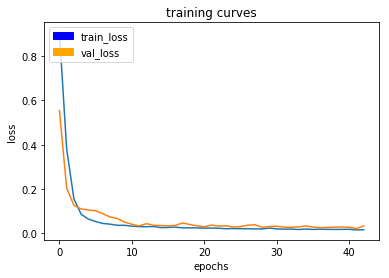

70/70 [==============================] - 66s - loss: 0.0170 - val_loss: 0.0340
Epoch 44/100
69/70 [============================>.] - ETA: 0s - loss: 0.0181

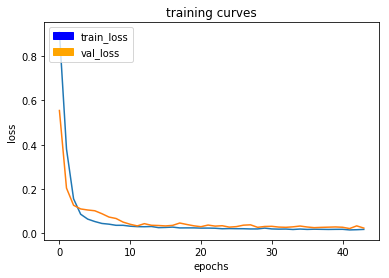

70/70 [==============================] - 65s - loss: 0.0181 - val_loss: 0.0241
Epoch 45/100
69/70 [============================>.] - ETA: 0s - loss: 0.0166

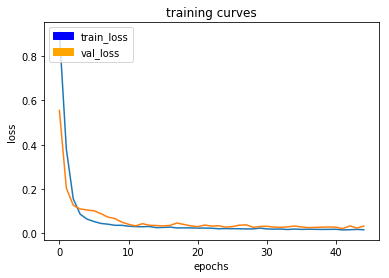

70/70 [==============================] - 66s - loss: 0.0166 - val_loss: 0.0331
Epoch 46/100
69/70 [============================>.] - ETA: 0s - loss: 0.0178

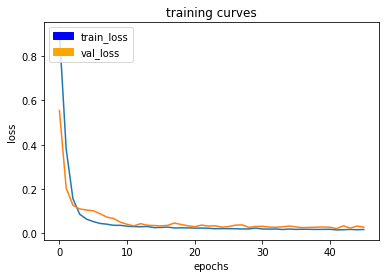

70/70 [==============================] - 66s - loss: 0.0178 - val_loss: 0.0284
Epoch 47/100
69/70 [============================>.] - ETA: 0s - loss: 0.0167

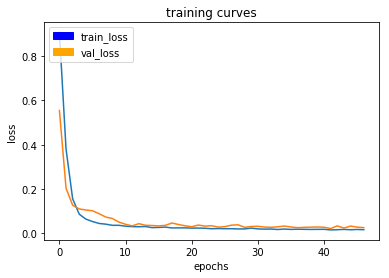

70/70 [==============================] - 66s - loss: 0.0168 - val_loss: 0.0260
Epoch 48/100
69/70 [============================>.] - ETA: 0s - loss: 0.0167

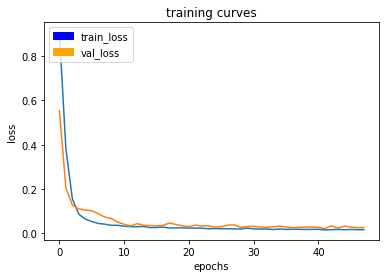

70/70 [==============================] - 65s - loss: 0.0168 - val_loss: 0.0263
Epoch 49/100
69/70 [============================>.] - ETA: 0s - loss: 0.0164

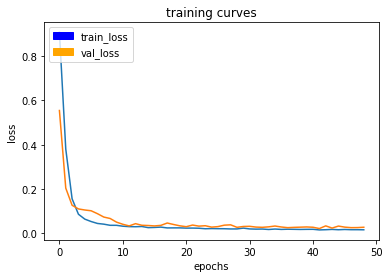

70/70 [==============================] - 66s - loss: 0.0163 - val_loss: 0.0278
Epoch 50/100
69/70 [============================>.] - ETA: 0s - loss: 0.0158

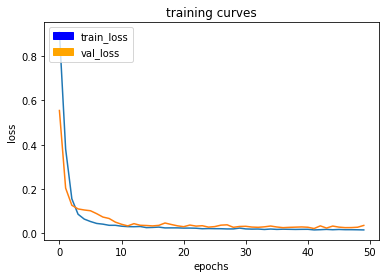

70/70 [==============================] - 66s - loss: 0.0158 - val_loss: 0.0360
Epoch 51/100
69/70 [============================>.] - ETA: 0s - loss: 0.0151

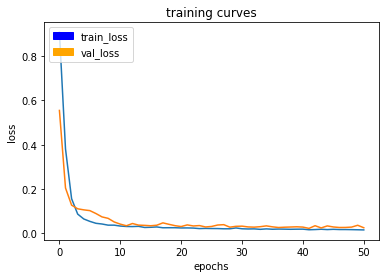

70/70 [==============================] - 66s - loss: 0.0151 - val_loss: 0.0249
Epoch 52/100
69/70 [============================>.] - ETA: 0s - loss: 0.0137

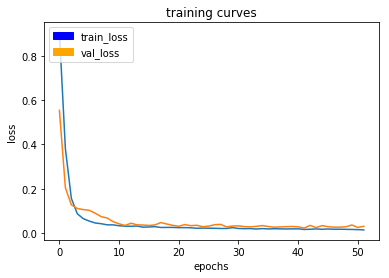

70/70 [==============================] - 66s - loss: 0.0137 - val_loss: 0.0301
Epoch 53/100
69/70 [============================>.] - ETA: 0s - loss: 0.0209

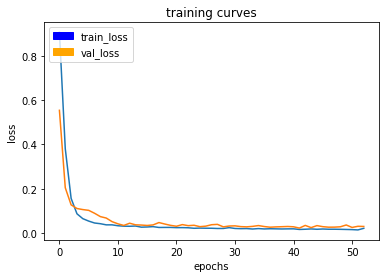

70/70 [==============================] - 66s - loss: 0.0209 - val_loss: 0.0293
Epoch 54/100
69/70 [============================>.] - ETA: 0s - loss: 0.0162

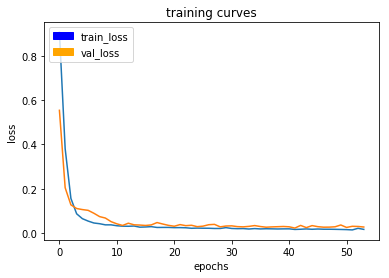

70/70 [==============================] - 66s - loss: 0.0161 - val_loss: 0.0268
Epoch 55/100
69/70 [============================>.] - ETA: 0s - loss: 0.0147

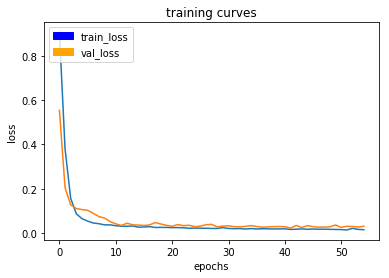

70/70 [==============================] - 65s - loss: 0.0147 - val_loss: 0.0303
Epoch 56/100
69/70 [============================>.] - ETA: 0s - loss: 0.0150

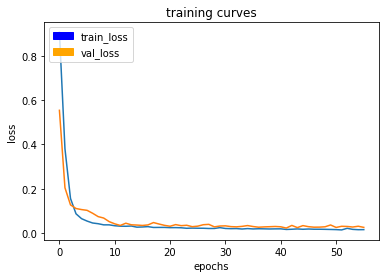

70/70 [==============================] - 65s - loss: 0.0149 - val_loss: 0.0251
Epoch 57/100
69/70 [============================>.] - ETA: 0s - loss: 0.0158

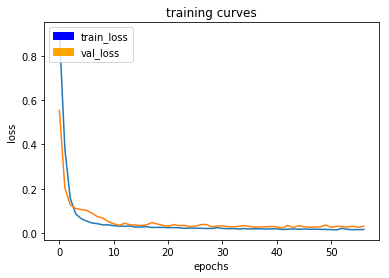

70/70 [==============================] - 66s - loss: 0.0158 - val_loss: 0.0304
Epoch 58/100
69/70 [============================>.] - ETA: 0s - loss: 0.0226

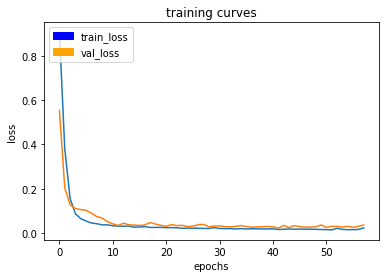

70/70 [==============================] - 66s - loss: 0.0225 - val_loss: 0.0359
Epoch 59/100
69/70 [============================>.] - ETA: 0s - loss: 0.0173

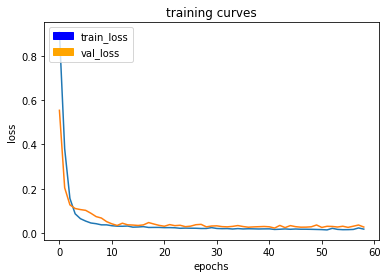

70/70 [==============================] - 65s - loss: 0.0173 - val_loss: 0.0267
Epoch 60/100
69/70 [============================>.] - ETA: 0s - loss: 0.0157

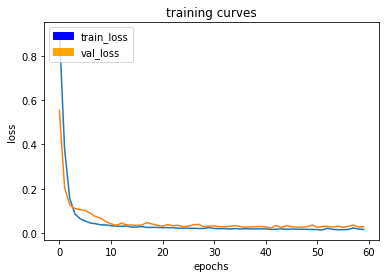

70/70 [==============================] - 66s - loss: 0.0157 - val_loss: 0.0282
Epoch 61/100
69/70 [============================>.] - ETA: 0s - loss: 0.0151

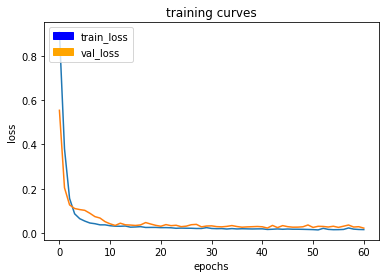

70/70 [==============================] - 66s - loss: 0.0151 - val_loss: 0.0218
Epoch 62/100
69/70 [============================>.] - ETA: 0s - loss: 0.0152

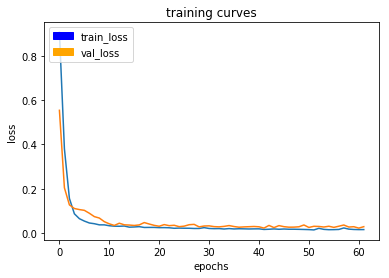

70/70 [==============================] - 66s - loss: 0.0152 - val_loss: 0.0283
Epoch 63/100
69/70 [============================>.] - ETA: 0s - loss: 0.0155

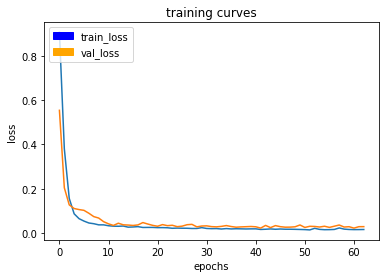

70/70 [==============================] - 65s - loss: 0.0155 - val_loss: 0.0285
Epoch 64/100
69/70 [============================>.] - ETA: 0s - loss: 0.0147

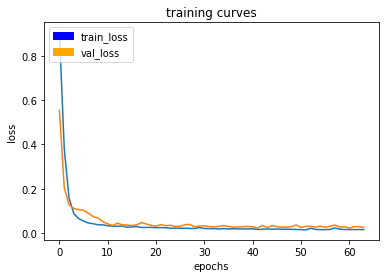

70/70 [==============================] - 66s - loss: 0.0147 - val_loss: 0.0248
Epoch 65/100
69/70 [============================>.] - ETA: 0s - loss: 0.0142

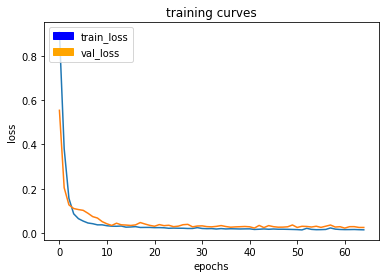

70/70 [==============================] - 66s - loss: 0.0141 - val_loss: 0.0247
Epoch 66/100
69/70 [============================>.] - ETA: 0s - loss: 0.0139

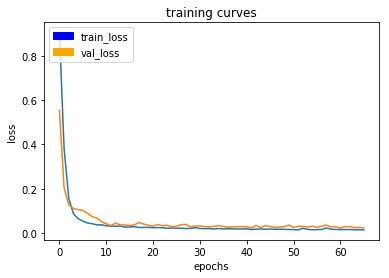

70/70 [==============================] - 65s - loss: 0.0139 - val_loss: 0.0232
Epoch 67/100
69/70 [============================>.] - ETA: 0s - loss: 0.0129

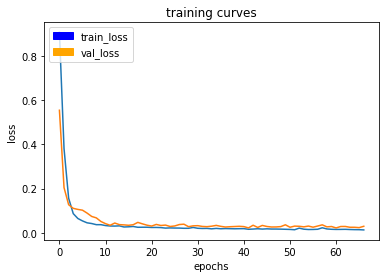

70/70 [==============================] - 66s - loss: 0.0129 - val_loss: 0.0293
Epoch 68/100
69/70 [============================>.] - ETA: 0s - loss: 0.0144

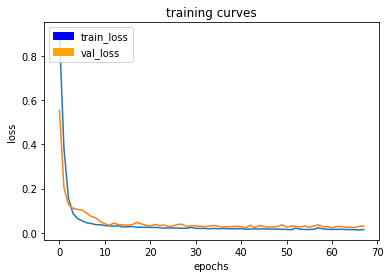

70/70 [==============================] - 66s - loss: 0.0144 - val_loss: 0.0302
Epoch 69/100
69/70 [============================>.] - ETA: 0s - loss: 0.0135

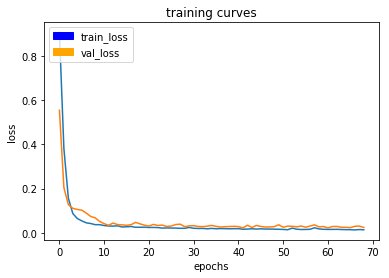

70/70 [==============================] - 66s - loss: 0.0135 - val_loss: 0.0241
Epoch 70/100
69/70 [============================>.] - ETA: 0s - loss: 0.0138

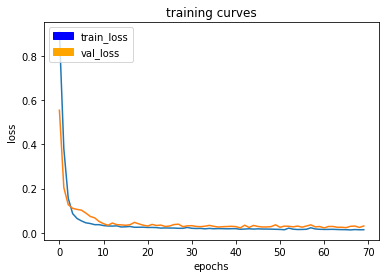

70/70 [==============================] - 66s - loss: 0.0138 - val_loss: 0.0307
Epoch 71/100
69/70 [============================>.] - ETA: 0s - loss: 0.0152

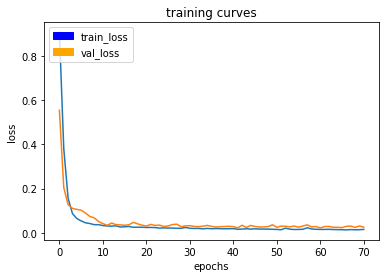

70/70 [==============================] - 66s - loss: 0.0152 - val_loss: 0.0252
Epoch 72/100
69/70 [============================>.] - ETA: 0s - loss: 0.0135

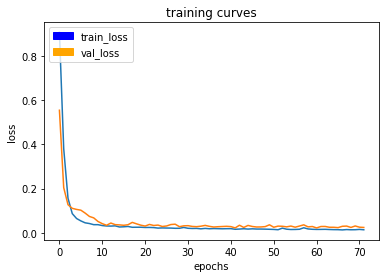

70/70 [==============================] - 66s - loss: 0.0135 - val_loss: 0.0240
Epoch 73/100
69/70 [============================>.] - ETA: 0s - loss: 0.0129

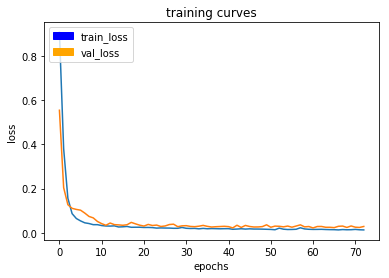

70/70 [==============================] - 66s - loss: 0.0129 - val_loss: 0.0285
Epoch 74/100
69/70 [============================>.] - ETA: 0s - loss: 0.0128

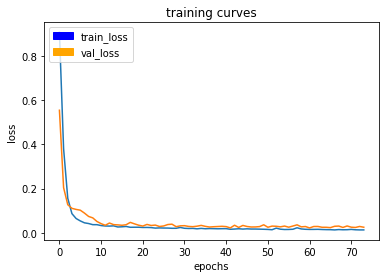

70/70 [==============================] - 65s - loss: 0.0128 - val_loss: 0.0249
Epoch 75/100
69/70 [============================>.] - ETA: 0s - loss: 0.0125

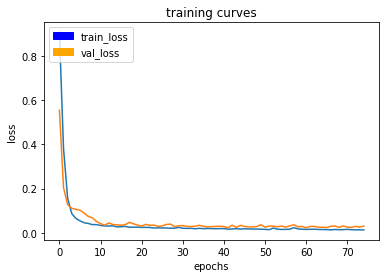

70/70 [==============================] - 66s - loss: 0.0125 - val_loss: 0.0298
Epoch 76/100
69/70 [============================>.] - ETA: 0s - loss: 0.0158

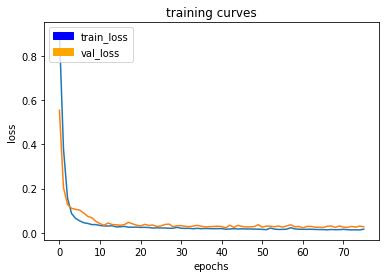

70/70 [==============================] - 66s - loss: 0.0158 - val_loss: 0.0266
Epoch 77/100
69/70 [============================>.] - ETA: 0s - loss: 0.0143

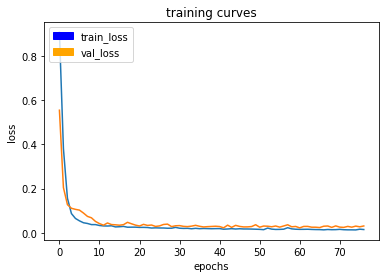

70/70 [==============================] - 66s - loss: 0.0143 - val_loss: 0.0304
Epoch 78/100
69/70 [============================>.] - ETA: 0s - loss: 0.0134

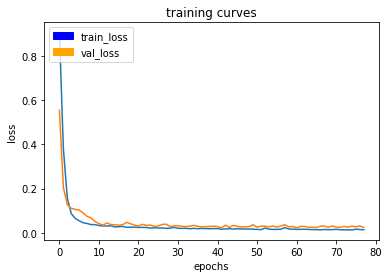

70/70 [==============================] - 66s - loss: 0.0134 - val_loss: 0.0237
Epoch 79/100
69/70 [============================>.] - ETA: 0s - loss: 0.0124

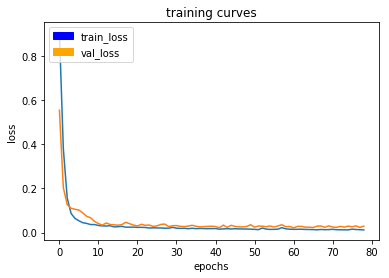

70/70 [==============================] - 65s - loss: 0.0124 - val_loss: 0.0297
Epoch 80/100
69/70 [============================>.] - ETA: 0s - loss: 0.0125

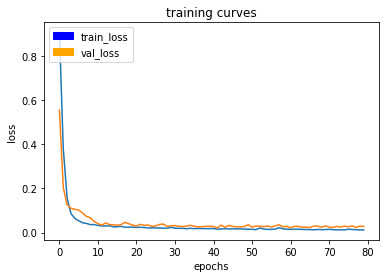

70/70 [==============================] - 66s - loss: 0.0125 - val_loss: 0.0281
Epoch 81/100
69/70 [============================>.] - ETA: 0s - loss: 0.0120

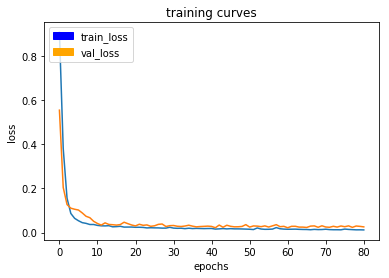

70/70 [==============================] - 66s - loss: 0.0120 - val_loss: 0.0258
Epoch 82/100
69/70 [============================>.] - ETA: 0s - loss: 0.0126

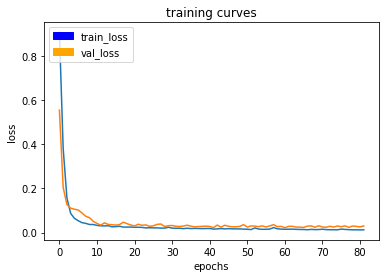

70/70 [==============================] - 66s - loss: 0.0126 - val_loss: 0.0301
Epoch 83/100
69/70 [============================>.] - ETA: 0s - loss: 0.0123

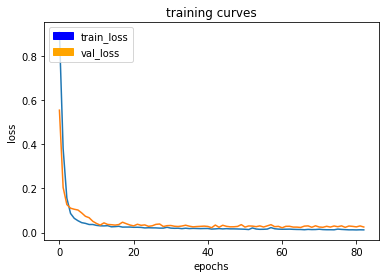

70/70 [==============================] - 66s - loss: 0.0122 - val_loss: 0.0252
Epoch 84/100
69/70 [============================>.] - ETA: 0s - loss: 0.0119

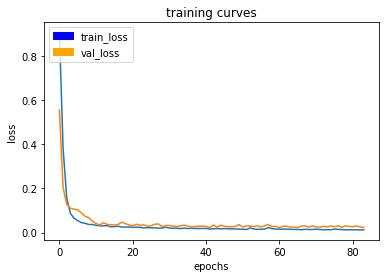

70/70 [==============================] - 66s - loss: 0.0118 - val_loss: 0.0232
Epoch 85/100
69/70 [============================>.] - ETA: 0s - loss: 0.0128

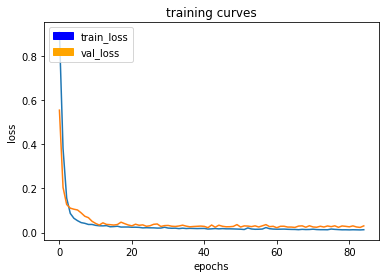

70/70 [==============================] - 66s - loss: 0.0127 - val_loss: 0.0301
Epoch 86/100
69/70 [============================>.] - ETA: 0s - loss: 0.0123

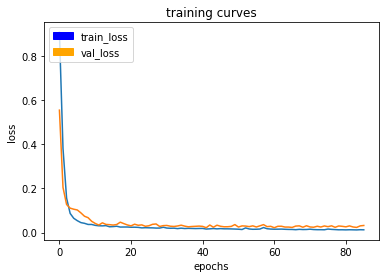

70/70 [==============================] - 66s - loss: 0.0123 - val_loss: 0.0320
Epoch 87/100
69/70 [============================>.] - ETA: 0s - loss: 0.0133

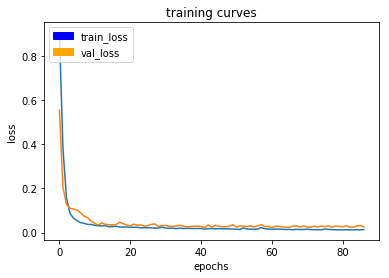

70/70 [==============================] - 66s - loss: 0.0133 - val_loss: 0.0256
Epoch 88/100
69/70 [============================>.] - ETA: 0s - loss: 0.0121

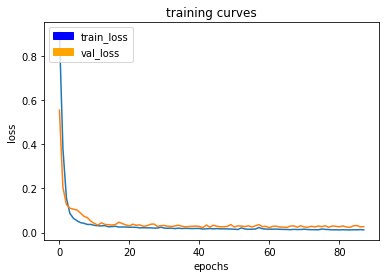

70/70 [==============================] - 66s - loss: 0.0121 - val_loss: 0.0265
Epoch 89/100
69/70 [============================>.] - ETA: 0s - loss: 0.0121

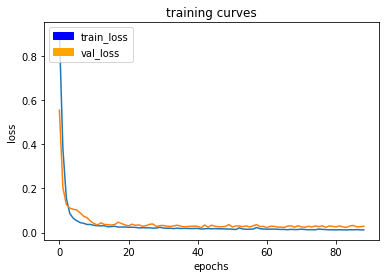

70/70 [==============================] - 66s - loss: 0.0121 - val_loss: 0.0285
Epoch 90/100
69/70 [============================>.] - ETA: 0s - loss: 0.0117

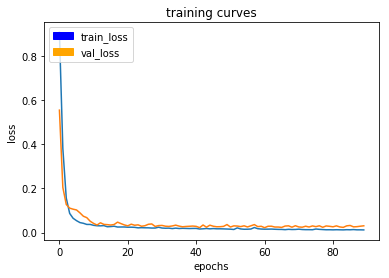

70/70 [==============================] - 66s - loss: 0.0117 - val_loss: 0.0304
Epoch 91/100
69/70 [============================>.] - ETA: 0s - loss: 0.0117

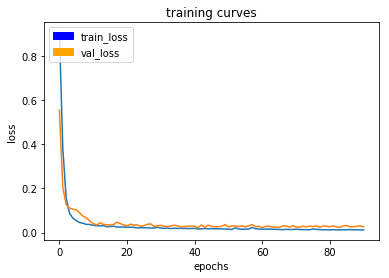

70/70 [==============================] - 66s - loss: 0.0117 - val_loss: 0.0254
Epoch 92/100
69/70 [============================>.] - ETA: 0s - loss: 0.0125

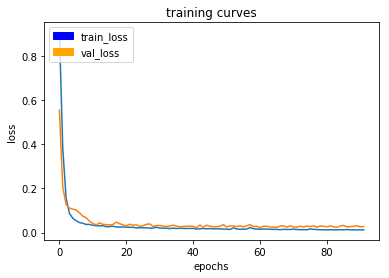

70/70 [==============================] - 66s - loss: 0.0125 - val_loss: 0.0271
Epoch 93/100
69/70 [============================>.] - ETA: 0s - loss: 0.0121

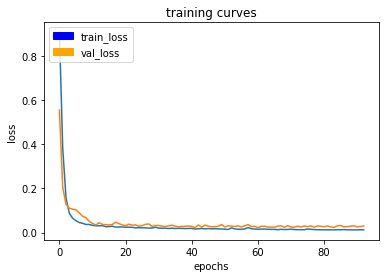

70/70 [==============================] - 65s - loss: 0.0121 - val_loss: 0.0299
Epoch 94/100
69/70 [============================>.] - ETA: 0s - loss: 0.0114

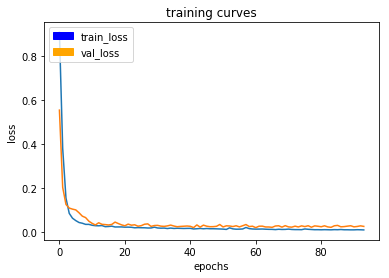

70/70 [==============================] - 66s - loss: 0.0114 - val_loss: 0.0274
Epoch 95/100
69/70 [============================>.] - ETA: 0s - loss: 0.0112

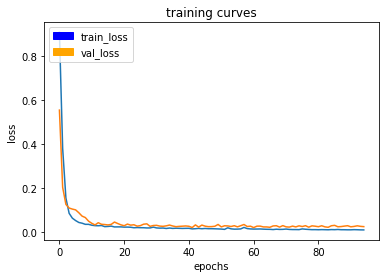

70/70 [==============================] - 66s - loss: 0.0113 - val_loss: 0.0261
Epoch 96/100
69/70 [============================>.] - ETA: 0s - loss: 0.0112

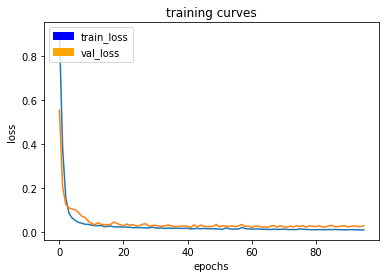

70/70 [==============================] - 66s - loss: 0.0112 - val_loss: 0.0309
Epoch 97/100
69/70 [============================>.] - ETA: 0s - loss: 0.0111

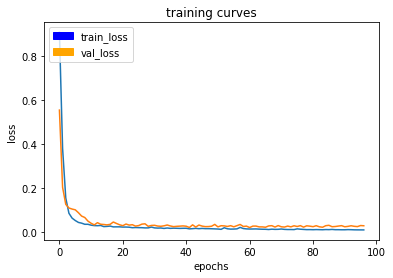

70/70 [==============================] - 66s - loss: 0.0110 - val_loss: 0.0299
Epoch 98/100
69/70 [============================>.] - ETA: 0s - loss: 0.0116

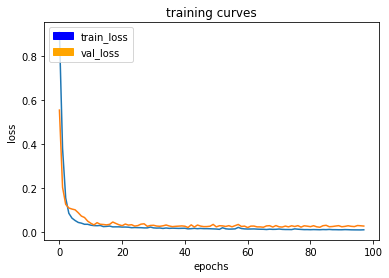

70/70 [==============================] - 65s - loss: 0.0116 - val_loss: 0.0285
Epoch 99/100
69/70 [============================>.] - ETA: 0s - loss: 0.0153

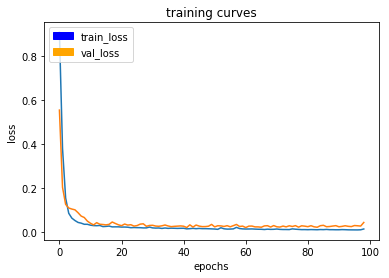

70/70 [==============================] - 66s - loss: 0.0153 - val_loss: 0.0448
Epoch 100/100
69/70 [============================>.] - ETA: 0s - loss: 0.0154

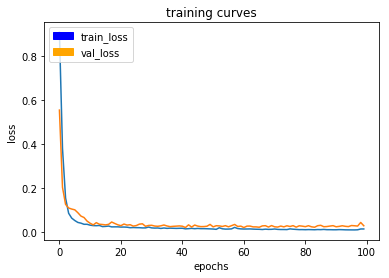

70/70 [==============================] - 66s - loss: 0.0153 - val_loss: 0.0299


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [12]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights'
restored_model = model_tools.load_network(weight_file_name)
print(restored_model)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [13]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

[('../data/sample_evaluation_data/following_images/images/1_run3cam1_00554.jpeg', '../data/sample_evaluation_data/following_images/masks/1__mask_00554.png', '../data/runs/following_images_run_1/1_run3cam1_00554_prediction.png'), ('../data/sample_evaluation_data/following_images/images/1_run3cam1_00217.jpeg', '../data/sample_evaluation_data/following_images/masks/1__mask_00217.png', '../data/runs/following_images_run_1/1_run3cam1_00217_prediction.png'), ('../data/sample_evaluation_data/following_images/images/0_run1cam1_00116.jpeg', '../data/sample_evaluation_data/following_images/masks/0__mask_00116.png', '../data/runs/following_images_run_1/0_run1cam1_00116_prediction.png'), ('../data/sample_evaluation_data/following_images/images/0_run1cam1_00759.jpeg', '../data/sample_evaluation_data/following_images/masks/0__mask_00759.png', '../data/runs/following_images_run_1/0_run1cam1_00759_prediction.png'), ('../data/sample_evaluation_data/following_images/images/1_run3cam1_00793.jpeg', '../da

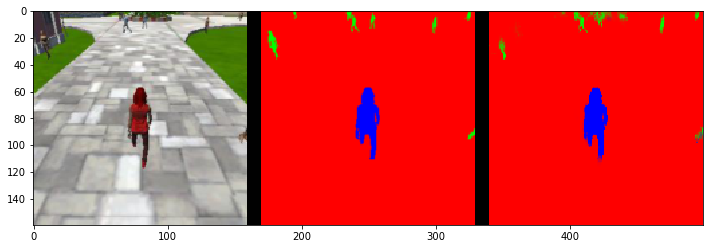

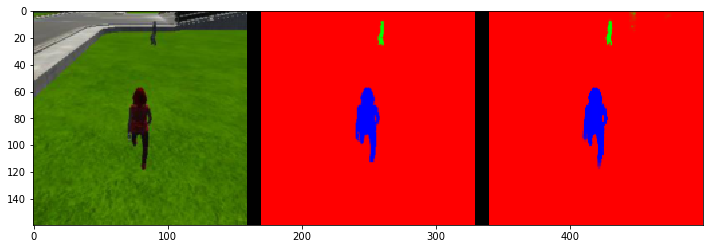

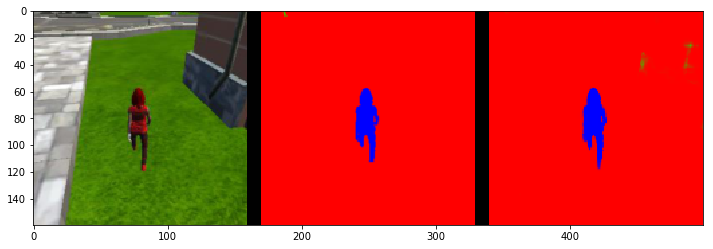

In [14]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
print(im_files)
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

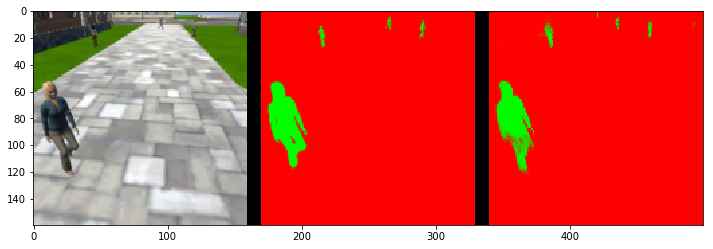

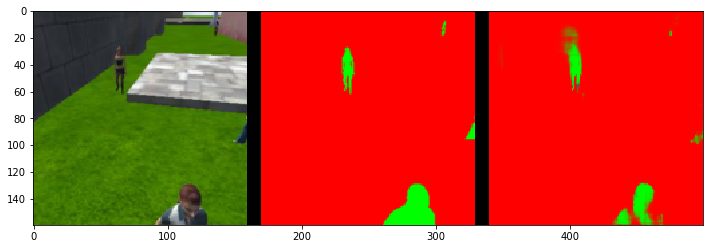

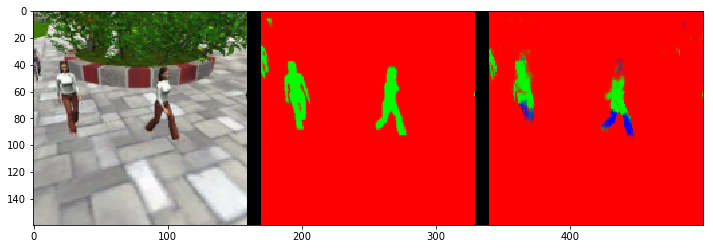

In [15]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

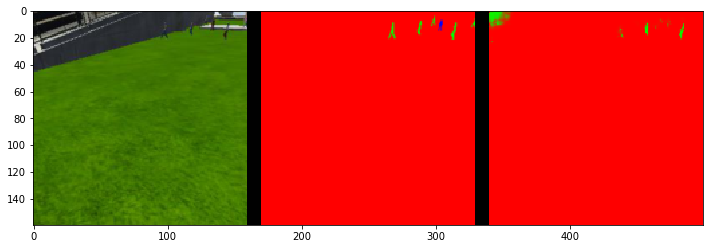

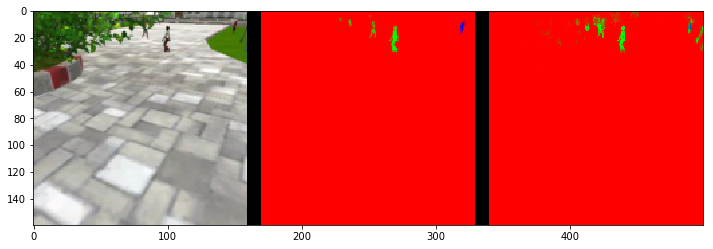

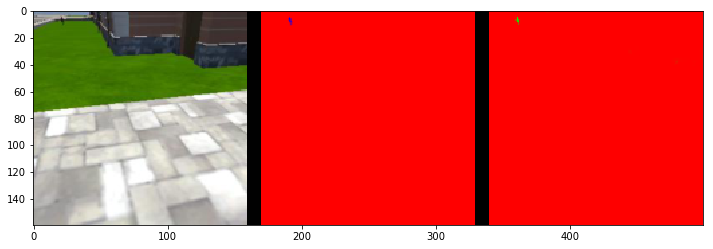

In [16]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [17]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9949158191021945
average intersection over union for other people is 0.3594693035939633
average intersection over union for the hero is 0.9134670346834033
number true positives: 539, number false positives: 0, number false negatives: 0


In [18]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9878213728324639
average intersection over union for other people is 0.727401240123358
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 132, number false negatives: 0


In [19]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9961938399273705
average intersection over union for other people is 0.46683584093805947
average intersection over union for the hero is 0.2953960764827484
number true positives: 165, number false positives: 6, number false negatives: 136


In [20]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7198364008179959


In [21]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.604431555583


In [22]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.435091835512
